# Regression Week 2: Multiple Regression (gradient descent)

In the first notebook we explored multiple regression using graphlab create. Now we will use graphlab along with numpy to solve for the regression weights with gradient descent.

In this notebook we will cover estimating multiple regression weights via gradient descent. You will:
* Add a constant column of 1's to a graphlab SFrame to account for the intercept
* Convert an SFrame into a Numpy array
* Write a predict_output() function using Numpy
* Write a numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size and tolerance.
* Use the gradient descent function to estimate regression weights for multiple features

# Import Library

Panda, numpy, scikit-learn

In [45]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn import linear_model 
from matplotlib import pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [21]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 
              'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 
              'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 
              'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [22]:
train = pd.read_csv("data/kc_house_train_data.csv", sep=",", dtype=dtype_dict)

In [26]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,constant
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0,1
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0,1
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0,1
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0,1
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0,1


In [23]:
test = pd.read_csv("data/kc_house_test_data.csv", sep=",", dtype=dtype_dict)

In [27]:
test.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0114101516,20140528T000000,310000.0,3.0,1.0,1430.0,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780.0,12697.0
1,9297300055,20150124T000000,650000.0,4.0,3.0,2950.0,5000,2,0,3,...,9,1980,970,1979,0,98126,47.5714,-122.375,2140.0,4000.0
2,1202000200,20141103T000000,233000.0,3.0,2.0,1710.0,4697,1.5,0,0,...,6,1710,0,1941,0,98002,47.3048,-122.218,1030.0,4705.0
3,8562750320,20141110T000000,580500.0,3.0,2.5,2320.0,3980,2,0,0,...,8,2320,0,2003,0,98027,47.5391,-122.070,2580.0,3980.0
4,7589200193,20141110T000000,535000.0,3.0,1.0,1090.0,3000,1.5,0,0,...,8,1090,0,1929,0,98117,47.6889,-122.375,1570.0,5080.0


If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the other Week 2 notebook. For this notebook, however, we will work with the existing features.

# Convert to Numpy Array

In [28]:
def get_numpy_data(dataframe, features, output):
    dataframe['constant'] = 1 
    features = ['constant'] + features 
    
    features_sframe = dataframe[features]
    feature_matrix = features_sframe.values
    output_sarray = dataframe[output]
    output_array = output_sarray.values
    
    return(feature_matrix, output_array)

For testing let's use the 'sqft_living' feature and a constant as our features and price as our output:

In [38]:
(example_features, example_output) = get_numpy_data(train, ['sqft_living'], 'price') # the [] around 'sqft_living' makes it a list
print example_features[0,:] # this accesses the first row of the data the ':' indicates 'all columns'
print example_output[0] # and the corresponding output
print train.head(1)

[  1.00000000e+00   1.18000000e+03]
221900.0
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0       3.0        1.0       1180.0   

   sqft_lot floors  waterfront  view    ...     sqft_above  sqft_basement  \
0      5650      1           0     0    ...           1180              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257         1340.0   

   sqft_lot15  constant  
0      5650.0         1  

[1 rows x 22 columns]


# Predicting output given regression weights

Suppose we had the weights [1.0, 1.0] and the features [1.0, 1180.0] and we wanted to compute the predicted output 1.0\*1.0 + 1.0\*1180.0 = 1181.0 this is the dot product between these two arrays. If they're numpy arrayws we can use np.dot() to compute this:

In [39]:
my_weights = np.array([1., 1.]) # the example weights
my_features = example_features[0,] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print predicted_value

1181.0


np.dot() also works when dealing with a matrix and a vector. Recall that the predictions from all the observations is just the RIGHT (as in weights on the right) dot product between the features *matrix* and the weights *vector*. With this in mind finish the following predict_output function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [40]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

If you want to test your code run the following cell:

In [41]:
test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1181.0
print test_predictions[1] # should be 2571.0

1181.0
2571.0


# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)^2

Where we have k features and a constant. So the derivative with respect to weight w[i] by the chain rule is:

2\*(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)\* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2\*error\*[feature_i]

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors. 

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [42]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    derivative = np.dot(errors,feature) * 2
    return(derivative)

To test your feature derivartive run the following:

In [44]:
(example_features, example_output) = get_numpy_data(train, ['sqft_living'], 'price') 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"
derivative = feature_derivative(errors, feature)
print derivative
print -np.sum(example_output)*2 # should be the same as derivative

-18752698920.0
-18752698920.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria

In [46]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    weights = np.array(initial_weights) # make sure it's a numpy array
    while not converged:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)    
        # compute the errors as predictions - output
        errors = predictions - output
        
        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(errors, feature_matrix[:,i])
            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            gradient_sum_squares += derivative**2
            # subtract the step size times the derivative from the current weight
            weights[i] -= derivative * step_size
            
        # compute the square-root of the gradient sum of squares to get the gradient magnitude:
        gradient_magnitude = np.sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
    return(weights)

A few things to note before we run the gradient descent. Since the gradient is a sum over all the data points and involves a product of an error and a feature the gradient itself will be very large since the features are large (squarefeet) and the output is large (prices). So while you might expect "tolerance" to be small, small is only relative to the size of the features. 

For similar reasons the step size will be much smaller than you might expect but this is because the gradient has such large values.

# Running the Gradient Descent as Simple Regression

Although the gradient descent is designed for multiple regression since the constant is now a feature we can use the gradient descent function to estimat the parameters in the simple regression on squarefeet. The folowing cell sets up the feature_matrix, output, initial weights and step size for the first model:

In [52]:
# let's test out the gradient descent
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train, simple_features, my_output)
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

Next run your gradient descent with the above parameters.

In [53]:
model1_weight = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance)
print model1_weight

[-46999.88716555    281.91211918]


How do your weights compare to those achieved in week 1 (don't expect them to be exactly the same)? 

**Quiz Question: What is the value of the weight for sqft_living -- the second element of ‘simple_weights’ (rounded to 1 decimal place)?**

Use your newly estimated weights and your predict_output() function to compute the predictions on all the TEST data (you will need to create a numpy array of the test feature_matrix and test output first:

In [54]:
(test_simple_feature_matrix, test_output) = get_numpy_data(test, simple_features, my_output)

Now compute your predictions using test_simple_feature_matrix and your weights from above.

In [55]:
model1_predictions = predict_output(test_simple_feature_matrix, model1_weight)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 1 (round to nearest dollar)?**

In [56]:
print model1_predictions[0]

356134.443255


Now that you have the predictions on test data, compute the RSS on the test data set. Save this value for comparison later. Recall that RSS is the sum of the squared errors (difference between prediction and output).

In [57]:
def RSS(feature_matrix, output, weights):
    predictions = predict_output(feature_matrix, weights)
    errors = predictions - output
    RSS = np.dot(errors, errors)
    return (RSS)

In [58]:
RSS(test_simple_feature_matrix, test_output, model1_weight)

275400044902128.31

# Running a multiple regression

Now we will use more than one actual feature. Use the following code to produce the weights for a second model with the following parameters:

In [60]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train, model_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

Use the above parameters to estimate the model weights. Record these values for your quiz.

In [61]:
model2_weight = regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance)
print model2_weight

[ -9.99999688e+04   2.45072603e+02   6.52795267e+01]


Use your newly estimated weights and the predict_output function to compute the predictions on the TEST data. Don't forget to create a numpy array for these features from the test set first!

In [63]:
(feature_matrix_test, output) = get_numpy_data(test, model_features, my_output)
predict_house_price = predict_output(feature_matrix_test,model2_weight)

In [64]:
RSS(feature_matrix_test, output, model2_weight)

270263443629803.53

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 2 (round to nearest dollar)?**

In [65]:
predict_house_price[0]

366651.41162949387

What is the actual price for the 1st house in the test data set?

In [68]:
test[:1]['price']

0    310000.0
Name: price, dtype: float64

**Quiz Question: Which estimate was closer to the true price for the 1st house on the TEST data set, model 1 or model 2?**

Now use your predictions and the output to compute the RSS for model 2 on TEST data.

##### Answer : model1

**Quiz Question: Which model (1 or 2) has lowest RSS on all of the TEST data? **

##### Answer : model2

## Visualize Model1 

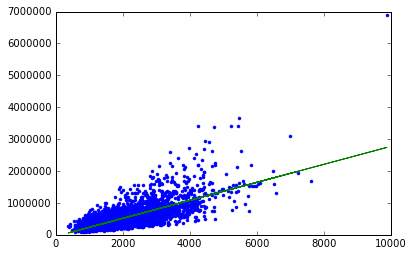

In [86]:
plt.plot(test[:]['sqft_living'],test[:]['price'],'.',
        test[:]['sqft_living'],model1_predictions,'-')

In [92]:
from mpl_toolkits.mplot3d import Axes3D

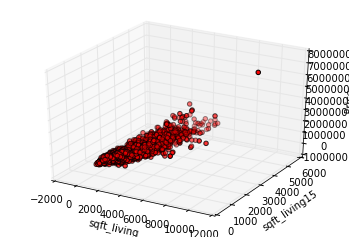

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test[:]['sqft_living'],test[:]['sqft_living15'], test[:]['price'],c='r', marker='o')
ax.set_xlabel('sqft_living')
ax.set_ylabel('sqft_living15')
ax.set_zlabel('Price')